In [39]:
import random
import numpy as np
import torch
import os
import pathlib
import pickle
import pandas as pd
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from Performance import performance_evaluation
perfs = performance_evaluation()

from Performance import H2h_Regret_Evaluation
h2h_regret_eva = H2h_Regret_Evaluation()

from Data import Data_Simulator
DS_Obj = Data_Simulator()

from Oracle import Oracle_Processing
Oracle_Proc = Oracle_Processing()

from OLS import OLS_Processing
OLS_Proc = OLS_Processing()

from DDR import DDR_Processing
DDR_Proc = DDR_Processing()

from PYEPO import EPO_Processing
PYEPO_Proc = EPO_Processing()

from Data_Load_Store import Load_Store_Methods
Data_LSM = Load_Store_Methods()

In [40]:
def run_all_approaches(DataPath,mu_all,lamb_all,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process):
        
        x_test_all,c_test_all,x_train_all,c_train_all,noise_train_all,noise_test_all,W_star_all = Data_LSM.load_input_data(DataPath)

        cost_Oracle_Post_all,cost_Oracle_Ante_all = Oracle_Proc.Implement_Oracle(arcs, grid,mis,bump,\
                                                                    W_star_all,x_test_all,noise_test_all,\
                                                                    iteration_all,num_feat,data_generation_process)
        
        cost_OLS_Post_all,cost_OLS_Ante_all = OLS_Proc.Implement_OLS(arcs, grid,mis,bump,\
                                                            W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,\
                                                            iteration_all,num_feat,data_generation_process)

        cost_DDR_Post_all,cost_DDR_Ante_all = DDR_Proc.Implement_DDR(mu_all,lamb_all,arcs, grid,mis,bump,\
                                                                    W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,\
                                                                        iteration_all,num_feat,data_generation_process)

        Data_LSM.store_Oracle_OLS_DDR_Cost(DataPath,cost_Oracle_Post_all,cost_Oracle_Ante_all,\
                                  cost_OLS_Post_all,cost_OLS_Ante_all,\
                                  cost_DDR_Post_all,cost_DDR_Ante_all)

In [41]:
def run_EPO_approaches(DataPath,method_names,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process):
        
        x_test_all,c_test_all,x_train_all,c_train_all,noise_train_all,noise_test_all,W_star_all = Data_LSM.load_input_data(DataPath)

        batch_size = 20
        num_epochs = 1000
        # from PYEPO import PyEPO_Method
        # epo_runner = PyEPO_Method()
        # method_names = ["spo+"]
        cost_EPO_Post_all,cost_EPO_Ante_all = PYEPO_Proc.Implement_EPO(DataPath,iteration_all,batch_size,num_epochs,method_names,\
                                                    W_star_all,bump,x_train_all,c_train_all,x_test_all,noise_test_all,\
                                                    arcs,grid,perfs,num_feat,mis,data_generation_process)

        with open(DataPath+'cost_'+method_names[0]+'_Post_all.pkl', "wb") as tf:
            pickle.dump(cost_EPO_Post_all,tf)
        with open(DataPath+'cost_'+method_names[0]+'_Ante_all.pkl', "wb") as tf:
            pickle.dump(cost_EPO_Ante_all,tf)

In [42]:
from scipy.stats import gaussian_kde
from matplotlib import gridspec
import seaborn as sns
import matplotlib.pyplot as plt
def Upright_Figure(all_x, all_y, figure_name, size = (5, 5), move = [-0.07, 0.07, 0.35, 0.55], 
                        ymin = 0, ymax=100,xmin = 0,xmax = 100):
    
    data = np.asarray([all_x,all_y])

    ####### Obtain KDE  
    #KDE for top marginal
    kde_X = gaussian_kde(data[0])
    #KDE for right marginal
    kde_Y = gaussian_kde(data[1])

    x = np.linspace(0, 100, 100)
    y = np.linspace(ymin, ymax, 100)

    dx = kde_X(x) # X-marginal density
    dy = kde_Y(y) # Y-marginal density

    #Define grid for subplots
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios = [1, 3])

    ####### Create scatter plot
    fig = plt.figure(figsize = size)
    ax = plt.subplot(gs[1, 0])
    cax = ax.scatter(data[0], data[1], s = 15, color='#003D7C', marker = "o", edgecolors = "#EF7C00")
    plt.xlabel('Head-to-head (%)')

    plt.ylabel('Regret reduction (%)') #pio
    plt.vlines(50, ymin, ymax, linestyle="dashed", alpha = 0.8,color = 'k')
    plt.hlines(0, xmin, xmax, linestyle="dashed", alpha = 0.8,color = 'k')

    # ####### Create Y-marginal (right)
    axr = plt.subplot(gs[1, 1], xticks = [], yticks = [], frameon = False)
    axr.plot(dy, y, color = 'black')

    axr.fill_betweenx(y, 0, dy, where = y <= 0.01, alpha = 1, color='#EF7C00')
    axr.fill_betweenx(y, 0, dy, where = y >= 0, alpha = 1, color='#003D7C')

    leftarea = np.round( sum(n <= 0 for n in all_y)/len(all_y),2 )
    rightarea = np.round( sum(n > 0 for n in all_y)/len(all_y),2 )

    axr.annotate(leftarea, xy=(0.15, abs(ymin)/(ymax - ymin) + move[0]), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)
    axr.annotate(rightarea, xy=(0.15, abs(ymin)/(ymax - ymin) + move[1]), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)

    # ####### Create X-marginal (top)
    axt = plt.subplot(gs[0,0], frameon = False, yticks = [], xticks = [])
    #base = pyplot.gca().transData
    #rot = transforms.Affine2D().rotate_deg(180)
    axt.plot(x, dx, color = 'black')
    axt.fill_between(x, 0, dx, where = x >= 49.9, alpha= 1, color = '#003D7C')
    axt.fill_between(x, 0, dx, where = x <= 50, alpha= 1, color = '#EF7C00')

    #     axt.invert_yaxis()
    leftarea = np.round( sum(n <= 50 for n in all_x)/len(all_x),2 )
    rightarea = np.round( sum(n > 50 for n in all_x)/len(all_x),2 )

    axt.annotate(leftarea, xy=(move[2], 0.15), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)
    axt.annotate(rightarea, xy=(move[3], 0.15), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)

    # ####### Bring the marginals closer to the scatter plot and save eps file
    fig.tight_layout(pad = 1)
    # # plt.savefig(figure_name + '.eps', format='eps')
    plt.savefig(figure_name + '.pdf', format='pdf')

### Parameters

In [26]:
grid = (3,3) # grid size
from Network import network_design
Network = network_design()
arcs,arc_index_mapping = Network._getArcs(grid)

num_test = 1000
lower = 0 # coef lower bound
upper = 1 # coef upper bound
d = (grid[0] - 1) * (grid[0] - 1) * 2 + 2 * (grid[0] - 1) # num of arcs
num_nodes = grid[0]*grid[0]
coef_seed = 1

x_dist = 'uniform'
e_dist = 'normal'
x_low = -2
x_up = 2
x_mean = 2
x_var = 2
bump = 100

In [43]:
data_generation_process = "SPO_Data_Generation"
# data_generation_process = "DDR_Data_Generation"
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
project_directory = os.path.dirname(os.path.dirname(os.path.dirname(parent_directory)))
DataPath_Parent = project_directory + '/Data_JOC_R1/Shortest_Path/SPO_High_Mis_' + data_generation_process + f'/{grid[0]}by{grid[1]}_grid/'
pathlib.Path(DataPath_Parent).mkdir(parents=True, exist_ok=True)
print("DataPath_parent:", DataPath_Parent)

DataPath_parent: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/SPO_High_Mis_SPO_Data_Generation/3by3_grid/


In [44]:
Result_dir = DataPath_Parent + "Result/"
pathlib.Path(Result_dir).mkdir(parents=True, exist_ok=True)

#### Impact of sample size

In [65]:
num_feat = 5 # size of feature
p = num_feat
e = 0.5 # scale of normal std or the range of uniform. For the error term
alpha = e # scale of normal std or the range of uniform. For the error term
iteration_all = np.arange(0,100)
batch_size = 20
num_epochs = 1000
num_train = 500
mu_all = [0.75]
lamb_all = [0.8]
deg_all = [1.0,2.0, 4.0, 6.0, 8.0] # polynomial degree
for deg in deg_all:
    # deg = 8.0 # polynomial degree
    mis = deg # model misspecification

    DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
    pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
    print("DataPath:", DataPath)
    
    x_test_all, c_test_all, x_train_all, c_train_all,noise_train_all,noise_test_all,W_star_all = \
    DS_Obj.Simulator(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump)

    Data_LSM.store_input_data(DataPath,x_test_all,c_test_all,x_train_all,c_train_all,noise_test_all,noise_train_all,W_star_all)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/SPO_High_Mis_SPO_Data_Generation/3by3_grid/data_size=500_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/SPO_High_Mis_SPO_Data_Generation/3by3_grid/data_size=500_deg=2.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/SPO_High_Mis_SPO_Data_Generation/3by3_grid/data_size=500_deg=4.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/SPO_High_Mis_SPO_Data_Generation/3by3_grid/data_size=500_deg=6.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/SPO_High_Mis_SPO_Data_Ge

In [66]:
for deg in deg_all:
    mis = deg # model misspecification
    DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
    print("DataPath:", DataPath)
    run_all_approaches(DataPath,mu_all,lamb_all,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)
    method_names = ["spo+"]
    run_EPO_approaches(DataPath,method_names,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/SPO_High_Mis_SPO_Data_Generation/3by3_grid/data_size=500_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
Oracle: iter= 20 ,cost_Oracle_Ante= 15.096535898629712
Oracle: iter= 40 ,cost_Oracle_Ante= 14.590733464812468
Oracle: iter= 60 ,cost_Oracle_Ante= 15.022101085286174
Oracle: iter= 80 ,cost_Oracle_Ante= 14.867069378054255
OLS: iter= 20 ,cost_OLS_Ante= 15.12187223704079
OLS: iter= 40 ,cost_OLS_Ante= 14.617217503266208
OLS: iter= 60 ,cost_OLS_Ante= 15.036388146202594
OLS: iter= 80 ,cost_OLS_Ante= 14.883867265629533
DDR: iter= 20 ,mu= 0.75 ,lamb= 0.8 ,cost_DDR_Ante = 15.121498863313887
DDR: iter= 40 ,mu= 0.75 ,lamb= 0.8 ,cost_DDR_Ante = 14.617826803486285
DDR: iter= 60 ,mu= 0.75 ,lamb= 0.8 ,cost_DDR_Ante = 15.036334813418883
DDR: iter= 80 ,mu= 0.75 ,lamb= 0.8 ,cost_DDR_Ante = 14.884368154442942
['spo+'] : iter= 20 ,cost_EPO_Ante= 15.150272401127499
['spo+'] : iter= 40 ,cost_E

In [77]:
regret_DDR_vs_SPO_d_ante_Dict = {}; h2h_DDR_vs_SPO_d_ante_Dict = {}
for mu in mu_all:
    for lamb in lamb_all:
        regret_d_ante = np.zeros(len(deg_all)); h2h_d_ante = np.zeros(len(deg_all))
        _index = 0
        for deg in deg_all:
            mis = deg # model misspecification
            DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
            print("DataPath:", DataPath)

            cost_Oracle_Post_all,cost_Oracle_Ante_all,cost_OLS_Post_all,cost_OLS_Ante_all,cost_DDR_Post_all,cost_DDR_Ante_all = Data_LSM.load_cost_data(DataPath)
            with open(DataPath+'cost_spo+_Ante_all.pkl', "rb") as tf:
                cost_SPO_Ante_all = pickle.load(tf)            
            h2h_d_ante[_index], regret_d_ante[_index] = h2h_regret_eva.calculate_h2h_regret(mu,lamb,iteration_all,\
                                cost_DDR_Post_all,cost_OLS_Post_all,cost_Oracle_Post_all,\
                                    cost_DDR_Ante_all,cost_SPO_Ante_all,cost_Oracle_Ante_all)
            _index = _index + 1
        regret_DDR_vs_SPO_d_ante_Dict[mu,lamb] = regret_d_ante
        h2h_DDR_vs_SPO_d_ante_Dict[mu,lamb] = h2h_d_ante
with open(Result_dir+'regret_DDR_vs_SPO_d_ante_Dict.pkl', "wb") as tf:
    pickle.dump(regret_DDR_vs_SPO_d_ante_Dict,tf)
with open(Result_dir+'h2h_DDR_vs_SPO_d_ante_Dict.pkl', "wb") as tf:
    pickle.dump(h2h_DDR_vs_SPO_d_ante_Dict,tf)


DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/SPO_High_Mis_SPO_Data_Generation/3by3_grid/data_size=500_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/SPO_High_Mis_SPO_Data_Generation/3by3_grid/data_size=500_deg=2.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/SPO_High_Mis_SPO_Data_Generation/3by3_grid/data_size=500_deg=4.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/SPO_High_Mis_SPO_Data_Generation/3by3_grid/data_size=500_deg=6.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/SPO_High_Mis_SPO_Data_Ge

In [78]:
h2h_ddr_vs_ols_ante = {}; cost_rd_ddr_vs_ols_ante = {}; regret_rd_ddr_vs_ols_ante = {}
h2h_ddr_vs_spo_ante = {}; cost_rd_ddr_vs_spo_ante = {}; regret_rd_ddr_vs_spo_ante = {}

for deg in deg_all:
    mis = deg # model misspecification
    DataPath = DataPath_Parent + f"data_size={num_train}_deg={deg}_e={e}_p={p}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
    print("DataPath:", DataPath)  

    cost_Oracle_Post_all,cost_Oracle_Ante_all,cost_OLS_Post_all,cost_OLS_Ante_all,cost_DDR_Post_all,cost_DDR_Ante_all = Data_LSM.load_cost_data(DataPath)
    
    with open(DataPath+'cost_spo+_Ante_all.pkl', "rb") as tf:
        cost_SPO_Ante_all = pickle.load(tf)
    for mu in mu_all:
        for lamb in lamb_all:
            h2h_ddr_vs_ols_ante[deg,mu,lamb],regret_rd_ddr_vs_ols_ante[deg,mu,lamb] \
                = h2h_regret_eva.calculate_DDR_vs_Others_h2h_regret(mu,lamb,iteration_all,\
                                                                    cost_DDR_Ante_all,cost_OLS_Ante_all,cost_Oracle_Ante_all)

            h2h_ddr_vs_spo_ante[deg,mu,lamb],regret_rd_ddr_vs_spo_ante[deg,mu,lamb] \
                = h2h_regret_eva.calculate_DDR_vs_Others_h2h_regret(mu,lamb,iteration_all,\
                                                                    cost_DDR_Ante_all,cost_SPO_Ante_all,cost_Oracle_Ante_all)

    print("deg = ",deg)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/SPO_High_Mis_SPO_Data_Generation/3by3_grid/data_size=500_deg=1.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
deg =  1.0
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/SPO_High_Mis_SPO_Data_Generation/3by3_grid/data_size=500_deg=2.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
deg =  2.0
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/SPO_High_Mis_SPO_Data_Generation/3by3_grid/data_size=500_deg=4.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
deg =  4.0
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/SPO_High_Mis_SPO_Data_Generation/3by3_grid/data_size=500_deg=6.0_e=0.5_p=5_num_test=1000_x_dist=uniform_e_dist=normal/
deg =  6.0
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_J

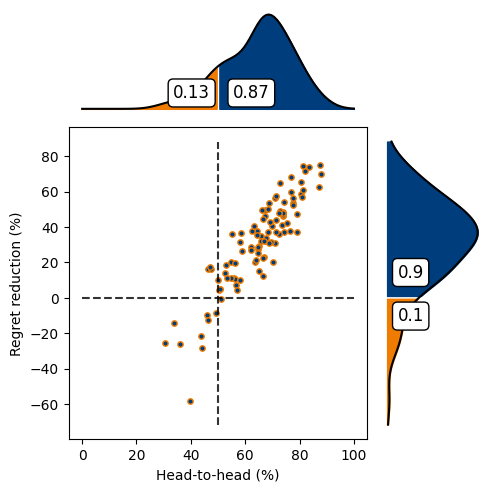

In [91]:
deg = deg_all[0]
mu = 0.75
lamb = 0.8
file_name = Result_dir + 'DDR_vs_SPO_mu='+str(mu)+"_lamb="+str(lamb)+"_ante_N="+str(num_train)
all_x = h2h_ddr_vs_spo_ante[deg,mu,lamb] * 100
all_y = regret_rd_ddr_vs_spo_ante[deg,mu,lamb] * 100
Figure_H2H_Regret.figure_plot_upright(all_x, all_y, file_name, size = (5, 5), move = [-0.07, 0.07, 0.35, 0.55], ysame = 0, yrange = [6,6], sublabel = '', ypio = 0)